In [ ]:
import pandas as pd

In [ ]:
df=pd.read_excel("/content/merged_feedback.xlsx")

In [ ]:
df.columns

Index(['Genre', 'Reports', 'Age', 'Year', 'Count', 'Gender', 'Nationality',
       'Resolution', 'Student Name', 'Ticket ID', 'Student_ID', 'GPA',
       'priority', 'status', 'report_time', 'report_hour', 'response_time',
       'response_days', 'Gmail', 'Feedback'],
      dtype='object')

In [ ]:
df["priority"].value_counts()

,count
priority,
medium,4028
low,2968
high,2015
critical,989


In [ ]:
df["Count"].value_counts()

,count
Count,
1,10000


Text Cleansing

In [ ]:
df["status"].value_counts()

,count
status,
resolved,4021
in_progress,2989
pending,1952
rejected,1038


In [ ]:
# Cell 1: Enhanced Imports and Configuration
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from tqdm import tqdm
import re
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns

# Enhanced Configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4
RESOLUTION_MODEL = "microsoft/deberta-v3-large"  # For resolution text
FEEDBACK_MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"  # Specialized for feedback/short text

In [ ]:
# Cell 2: Data Loading and Preparation (unchanged)
def load_data(file_path):
    """Load and preprocess the dataset"""
    df = pd.read_excel(file_path)

    # Basic cleaning
    text_cols = ['Resolution', 'Feedback']
    for col in text_cols:
        df[col] = df[col].fillna('').astype(str)

    return df

# Load your data
df = load_data("/content/merged_feedback.xlsx")
# df = df.iloc[100:500]

In [ ]:
# Cell 3: Enhanced Text Preprocessing
def preprocess_text(text):
    """Enhanced text preprocessing with emoji handling"""
    if not isinstance(text, str):
        return ""

    # Basic cleaning
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace

    # Enhanced cleaning
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    return text

# Preprocess text columns
df['Resolution_clean'] = df['Resolution'].apply(preprocess_text)
df['Feedback_clean'] = df['Feedback'].apply(preprocess_text)
df[['Resolution', 'Resolution_clean', 'Feedback', 'Feedback_clean']].head()

,Resolution,Resolution_clean,Feedback,Feedback_clean
0,Create a feedback system for international stu...,create a feedback system for international stu...,The university should be able to accept feedba...,the university should be able to accept feedba...
1,Provide access to online language courses and ...,provide access to online language courses and ...,It's not clear whether the student is aware of...,its not clear whether the student is aware of ...
2,Organize study groups for international studen...,organize study groups for international studen...,The student's solution to the international st...,the students solution to the international stu...
3,Develop a mobile app with resources for intern...,develop a mobile app with resources for intern...,The app could be a way of extending the social...,the app could be a way of extending the social...
4,Offer workshops on public speaking and present...,offer workshops on public speaking and present...,"As an English teacher, I know firsthand how di...",as an english teacher i know firsthand how dif...


In [ ]:
# Cell 4: Enhanced Model Setup with Specialized Feedback Model
class SentimentAnalyzer:
    def __init__(self, resolution_model=RESOLUTION_MODEL, feedback_model=FEEDBACK_MODEL, device=DEVICE):
        self.device = device

        # Resolution model (general text)
        self.resolution_tokenizer = AutoTokenizer.from_pretrained(resolution_model)
        self.resolution_model = AutoModelForSequenceClassification.from_pretrained(resolution_model).to(device)

        # Feedback model (specialized for short text/social media)
        self.feedback_tokenizer = AutoTokenizer.from_pretrained(feedback_model)
        self.feedback_model = AutoModelForSequenceClassification.from_pretrained(feedback_model).to(device)

        self.resolution_model.eval()
        self.feedback_model.eval()

    def predict_resolution_sentiment(self, texts, batch_size=BATCH_SIZE):
        """Predict sentiment for resolution text"""
        return self._predict_sentiment(texts, self.resolution_tokenizer, self.resolution_model, batch_size)

    def predict_feedback_sentiment(self, texts, batch_size=BATCH_SIZE):
        """Predict sentiment for feedback text using specialized model"""
        return self._predict_sentiment(texts, self.feedback_tokenizer, self.feedback_model, batch_size)

    def _predict_sentiment(self, texts, tokenizer, model, batch_size):
        """Generic batch prediction function"""
        results = []

        if not texts:
            return np.array([])

        for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
            batch = texts[i:i+batch_size]

            try:
                inputs = tokenizer(
                    batch,
                    padding=True,
                    truncation=True,
                    max_length=512,
                    return_tensors="pt"
                ).to(self.device)

                with torch.no_grad():
                    outputs = model(**inputs)

                probs = softmax(outputs.logits.cpu().numpy(), axis=1)

                # Unified score calculation (positive - negative)
                batch_scores = probs[:, -1] - probs[:, 0]  # Works for both 2-class and 3-class models
                results.extend(batch_scores)

            except Exception as e:
                print(f"Error processing batch {i//batch_size}: {str(e)}")
                results.extend([0] * len(batch))

        return np.array(results)

# Initialize enhanced analyzer
analyzer = SentimentAnalyzer()

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.p

In [ ]:
# Cell 5: Enhanced Sentiment Analysis Execution
print("Analyzing Resolution sentiments...")
df['Resolution_sentiment'] = analyzer.predict_resolution_sentiment(df['Resolution_clean'].tolist())

print("Analyzing Feedback sentiments with specialized model...")
df['Feedback_sentiment'] = analyzer.predict_feedback_sentiment(df['Feedback_clean'].tolist())

# Show results with enhanced model
df[['Resolution', 'Resolution_sentiment', 'Feedback', 'Feedback_sentiment']].head()

Analyzing Resolution sentiments...


Processing batches: 100%|██████████| 2500/2500 [1:31:04<00:00,  2.19s/it]


Analyzing Feedback sentiments with specialized model...


Processing batches: 100%|██████████| 2500/2500 [18:38<00:00,  2.24it/s]


,Resolution,Resolution_sentiment,Feedback,Feedback_sentiment
0,Create a feedback system for international stu...,-0.048579,The university should be able to accept feedba...,0.071199
1,Provide access to online language courses and ...,-0.047542,It's not clear whether the student is aware of...,-0.501654
2,Organize study groups for international studen...,-0.050582,The student's solution to the international st...,-0.596637
3,Develop a mobile app with resources for intern...,-0.059111,The app could be a way of extending the social...,0.549412
4,Offer workshops on public speaking and present...,-0.052218,"As an English teacher, I know firsthand how di...",0.650686


In [ ]:
# Cell 6: Enhanced Analysis with Better Weighting
def enhanced_analysis(df):
    """Enhanced analysis with better model integration"""
    # Normalize features
    df['response_days_norm'] = 1 / (1 + df['response_days'])

    # Status mapping
    status_mapping = {
        'resolved': 1.0,
        'in_progress': 0.7,
        'pending': 0.5,
        'rejected': 0.3,
    }
    df['status_score'] = df['status'].map(lambda x: status_mapping.get(x.lower(), 0.3))

    # Enhanced satisfaction score calculation
    # Higher weight given to feedback sentiment since we're using a specialized model
    df['satisfaction_score'] = (
        0.6 * df['Feedback_sentiment'] +  # Higher weight for specialized feedback analysis
        0.1 * df['Resolution_sentiment'] +
        0.15 * df['status_score'] +
        0.15 * df['response_days_norm']
    )

    # Apply sigmoid to bound between 0-1
    df['satisfaction_score'] = 1 / (1 + np.exp(-df['satisfaction_score']))

    # Categorize satisfaction levels with adjusted thresholds
    bins = [-np.inf, 0.45, 0.6, np.inf]  # Adjusted thresholds for better distribution
    labels = ['Dissatisfied', 'Neutral', 'Satisfied']
    df['satisfaction_level'] = pd.cut(df['satisfaction_score'], bins=bins, labels=labels)

    return df

# Run enhanced analysis
df = enhanced_analysis(df)
df[['status', 'status_score', 'satisfaction_score', 'satisfaction_level']].head()

,status,status_score,satisfaction_score,satisfaction_level
0,resolved,1.0,0.560162,Neutral
1,in_progress,0.7,0.469903,Neutral
2,pending,0.5,0.455480,Neutral
3,pending,0.5,0.631870,Satisfied
4,resolved,1.0,0.647092,Satisfied


<ipython-input-75-13a63fcd6365>:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-75-13a63fcd6365>:89: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



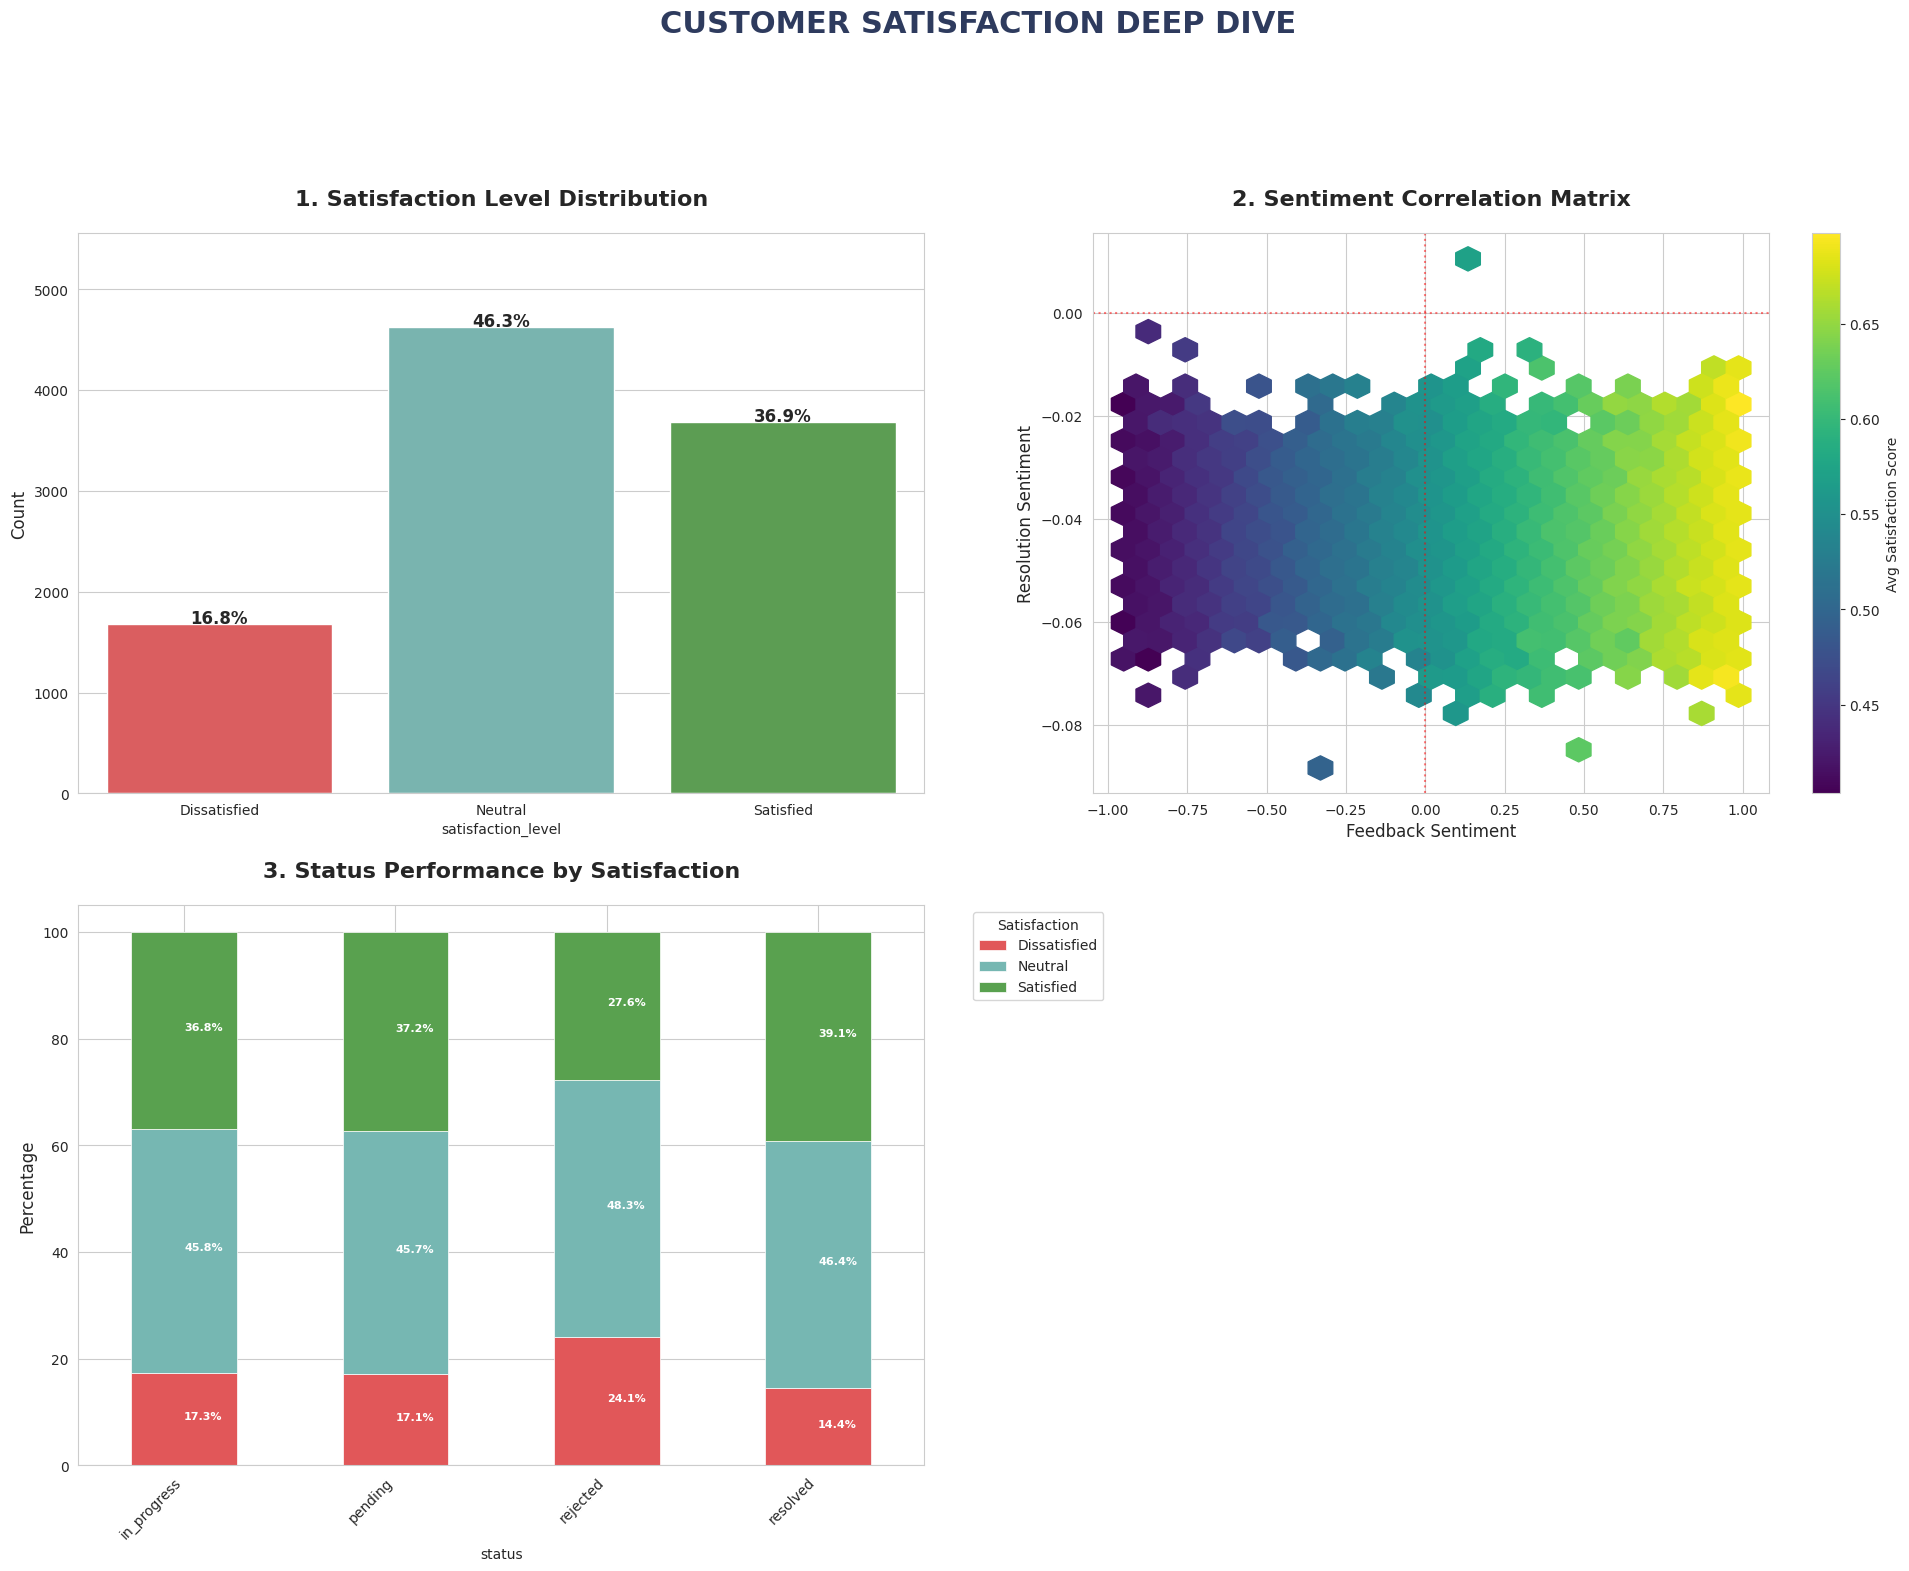

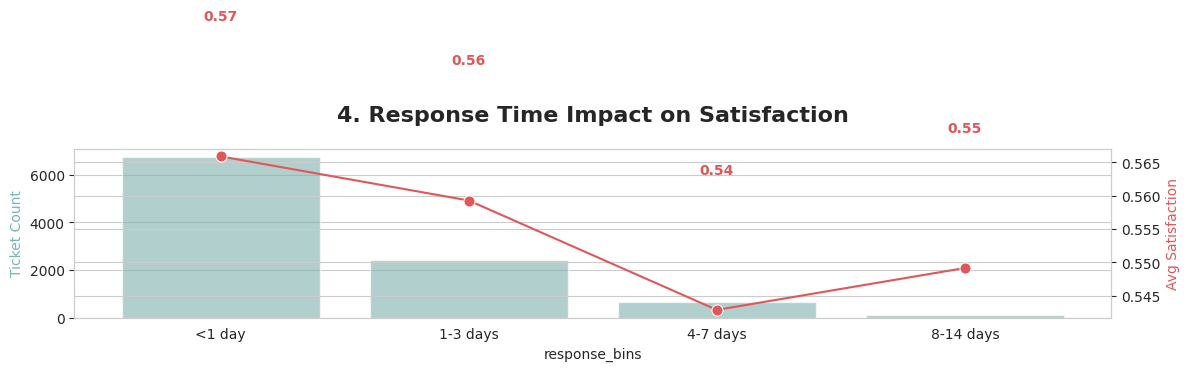

In [ ]:
# Cell 7++: Ultimate Visualization Dashboard with Bar Plots
def visualize_results(df):
    """Powerful visualizations with focused bar plot insights"""
    plt.figure(figsize=(24, 16))  # Adjusted for better bar plot display
    plt.suptitle("CUSTOMER SATISFACTION DEEP DIVE", fontsize=22, y=1.02, fontweight='bold', color='#2e3b5e')

    # Custom styling
    sns.set_style("whitegrid")
    satisfaction_palette = {'Dissatisfied':'#e15759', 'Neutral':'#76b7b2', 'Satisfied':'#59a14f'}
    sentiment_palette = {'Resolution_sentiment':'#4e79a7', 'Feedback_sentiment':'#f28e2b'}

    # =================================================================
    # PLOT 1: SATISFACTION LEVEL BREAKDOWN (BAR + PIE COMBO)
    # =================================================================
    plt.subplot(2, 2, 1)

    # Bar plot
    level_counts = df['satisfaction_level'].value_counts().sort_index()
    ax = sns.barplot(x=level_counts.index, y=level_counts, palette=satisfaction_palette, saturation=0.9)

    # Add percentages on bars
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 5,
                f'{height/total:.1%}',
                ha="center", fontsize=12, fontweight='bold')

    plt.title('1. Satisfaction Level Distribution', pad=20, fontsize=16, fontweight='bold')
    plt.ylabel('Count', fontsize=12)
    plt.ylim(0, level_counts.max() * 1.2)

    # =================================================================
    # PLOT 2: SENTIMENT VS SATISFACTION SCATTER MATRIX (POWERFUL!)
    # =================================================================
    plt.subplot(2, 2, 2)

    # Hexbin plot for density visualization
    hb = plt.hexbin(df['Feedback_sentiment'], df['Resolution_sentiment'],
                   C=df['satisfaction_score'], gridsize=25, cmap='viridis',
                   reduce_C_function=np.mean)

    plt.colorbar(hb, label='Avg Satisfaction Score')
    plt.title('2. Sentiment Correlation Matrix', pad=20, fontsize=16, fontweight='bold')
    plt.xlabel('Feedback Sentiment', fontsize=12)
    plt.ylabel('Resolution Sentiment', fontsize=12)
    plt.axhline(0, color='red', linestyle=':', alpha=0.5)
    plt.axvline(0, color='red', linestyle=':', alpha=0.5)

    # =================================================================
    # PLOT 3: STATUS PERFORMANCE BY SATISFACTION (STACKED BAR)
    # =================================================================
    plt.subplot(2, 2, 3)

    # Create stacked bar data
    status_level = pd.crosstab(df['status'], df['satisfaction_level'])
    status_level = status_level.div(status_level.sum(1), axis=0) * 100

    status_level.plot(kind='bar', stacked=True, color=satisfaction_palette,
                     edgecolor='white', linewidth=0.5, ax=plt.gca())

    plt.title('3. Status Performance by Satisfaction', pad=20, fontsize=16, fontweight='bold')
    plt.ylabel('Percentage', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(title='Satisfaction', bbox_to_anchor=(1.05, 1))

    # Add value labels
    for n, x in enumerate([*status_level.index.values]):
        for (proportion, y_loc) in zip(status_level.loc[x],
                                     status_level.loc[x].cumsum()):
            plt.text(x=n, y=(y_loc - proportion/2),
                    s=f'{proportion:.1f}%',
                    color="white", fontsize=8, fontweight='bold')

    # =================================================================


    # =================================================================
    # NEW PLOT 4: RESPONSE TIME IMPACT BAR PLOT (REPLACED RADAR)
    # =================================================================
    plt.figure(figsize=(12, 6))

    # Create response time bins
    df['response_bins'] = pd.cut(df['response_days'],
                                bins=[0, 1, 3, 7, 14, np.inf],
                                labels=['<1 day', '1-3 days', '4-7 days', '8-14 days', '15+ days'])

    # Calculate mean satisfaction by response time
    response_stats = df.groupby('response_bins')['satisfaction_score'].agg(['mean', 'count'])
    response_stats = response_stats[response_stats['count'] > 5]  # Filter small groups

    # Plot with twin axes
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # Bar plot (count)
    sns.barplot(x=response_stats.index, y='count', data=response_stats,
               color='#76b7b2', alpha=0.6, ax=ax1)

    # Line plot (mean satisfaction)
    sns.lineplot(x=response_stats.index, y='mean', data=response_stats,
                color='#e15759', marker='o', markersize=8, ax=ax2)

    ax1.set_ylabel('Ticket Count', color='#76b7b2')
    ax2.set_ylabel('Avg Satisfaction', color='#e15759')
    plt.title('4. Response Time Impact on Satisfaction', pad=20, fontsize=16, fontweight='bold')
    plt.xlabel('Response Time', fontsize=12)

    # Add value labels
    for x, y in zip(range(len(response_stats)), response_stats['mean']):
        ax2.text(x, y+0.02, f"{y:.2f}",
                ha='center', va='bottom', color='#e15759', fontweight='bold')

    plt.tight_layout()
    plt.show()


# Generate the ultimate dashboard
visualize_results(df)

In [ ]:
df.columns

Index(['Genre', 'Reports', 'Age', 'Year', 'Count', 'Gender', 'Nationality',
       'Resolution', 'Student Name', 'Ticket ID', 'Student_ID', 'GPA',
       'priority', 'status', 'report_time', 'report_hour', 'response_time',
       'response_days', 'Gmail', 'Feedback', 'Resolution_clean',
       'Feedback_clean', 'Resolution_sentiment', 'Feedback_sentiment',
       'response_days_norm', 'status_score', 'satisfaction_score',
       'satisfaction_level', 'response_bins'],
      dtype='object')

In [ ]:
df["satisfaction_level"].value_counts()

,count
satisfaction_level,
Neutral,4630
Satisfied,3689
Dissatisfied,1681


In [ ]:
df["satisfaction_score"].describe()

,satisfaction_score
count,10000.000000
mean,0.562699
std,0.088060
min,0.382522
25%,0.485700
50%,0.568254
75%,0.641620
max,0.706791


In [ ]:
final_data=df.sample(frac=1,random_state=42).reset_index(drop=True)

In [ ]:
final_data.to_excel("Final_Sentiment analysis.xlsx",index=False)
from google.colab import files
files.download("/content/Final_Sentiment analysis.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>